# MLB Catcher Defense Analysis (2018-2024)

This notebooks supports a technical report for identigying the best defensive catcher in baseball

The analysis uses:
    Principal Component Analysis to reduce dimensionality
    
    K-means clustering to group performance profiles
    
    A custom scoring model to rank catchers holistically
    
    Comparison of performance to salary (AAV) and age

### Step 1: Data Import and Cleaning

I begin by importing all necessary libraries as well as the Statcast data from 2018 to 2024 for all MLB catchers who caught at least 400 pitches in a season. Multiple datasets were merged by player ID and year to form a complete view of framing, throwing, blocking, and pop time. 

If any values were missing, I filled them with the median values for that column and incomplete player entries were removed.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib.request
import io
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


C:\Users\jtegs\Contacts\New folder\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('catcher_data_clean.csv')

In [3]:
df.head()

,player_id,player_name,team_name,year,pitches,age,contract(aav),catcher_blocking_runs,blocks_above_average,n_pbwp,...,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba,pop_2b_cs,pop_2b_sb,pop_3b_sba_count,pop_3b_sba,pop_3b_cs,pop_3b_sb,Unnamed: 57
0,595751,"Alfaro, Jorge",PHI,2018,3659,25,547000,-5,-19,58,...,0.73,45.00,1.92,1.9,1.94,1.00,1.49,\n,1.49,NaN
1,605131,"Barnes, Austin",LAD,2018,1690,28,555000,2,9,9,...,0.72,9.00,2.11,2.12,2.10,0.00,\n,\n,\n,NaN
2,571466,"Barnhart, Tucker",CIN,2018,4503,27,4000000,4,18,22,...,0.70,37.00,2.03,2.05,2.03,4.00,1.73,1.81,1.5,NaN
3,605170,"Caratini, Victor",CHC,2018,1337,24,547500,1,3,12,...,0.81,14.00,2.08,2.15,2.07,3.00,1.69,1.65,1.7,NaN
4,455139,"Chirinos, Robinson",TEX,2018,4158,34,2350000,4,14,28,...,81.10,0.76,21.00,2.04,2.08,2.03,3,1.64,\n,1.64


In [4]:
df.columns = df.columns.str.strip()

In [5]:
df['contract(aav)']

0        547000
1        555000
2       4000000
3        547500
4       2350000
         ...   
400     1000000
401     2730000
402    10000000
403      750000
404      760000
Name: contract(aav), Length: 405, dtype: int64

In [6]:
## This line selects a couple of key variables from each of the four major categories to run a correlation matrix.
key_variables =['runs_extra_strikes','strike_rate','catcher_blocking_runs','blocks_above_average'
               ,'catcher_stealing_runs','caught_stealing_above_average','rate_cs','arm_strength',
               'pop_time','exchange_time','age','contract(aav)','pitches']

**Correlation Matrix of Key Variables**

The correlation matrix shows some potential multicollinearity between some variables in the same category. There is perfect correlation between catcher_blocking_runs and block_above_average. The PCA helps to remove multicollinearity because it can group the variables differently.

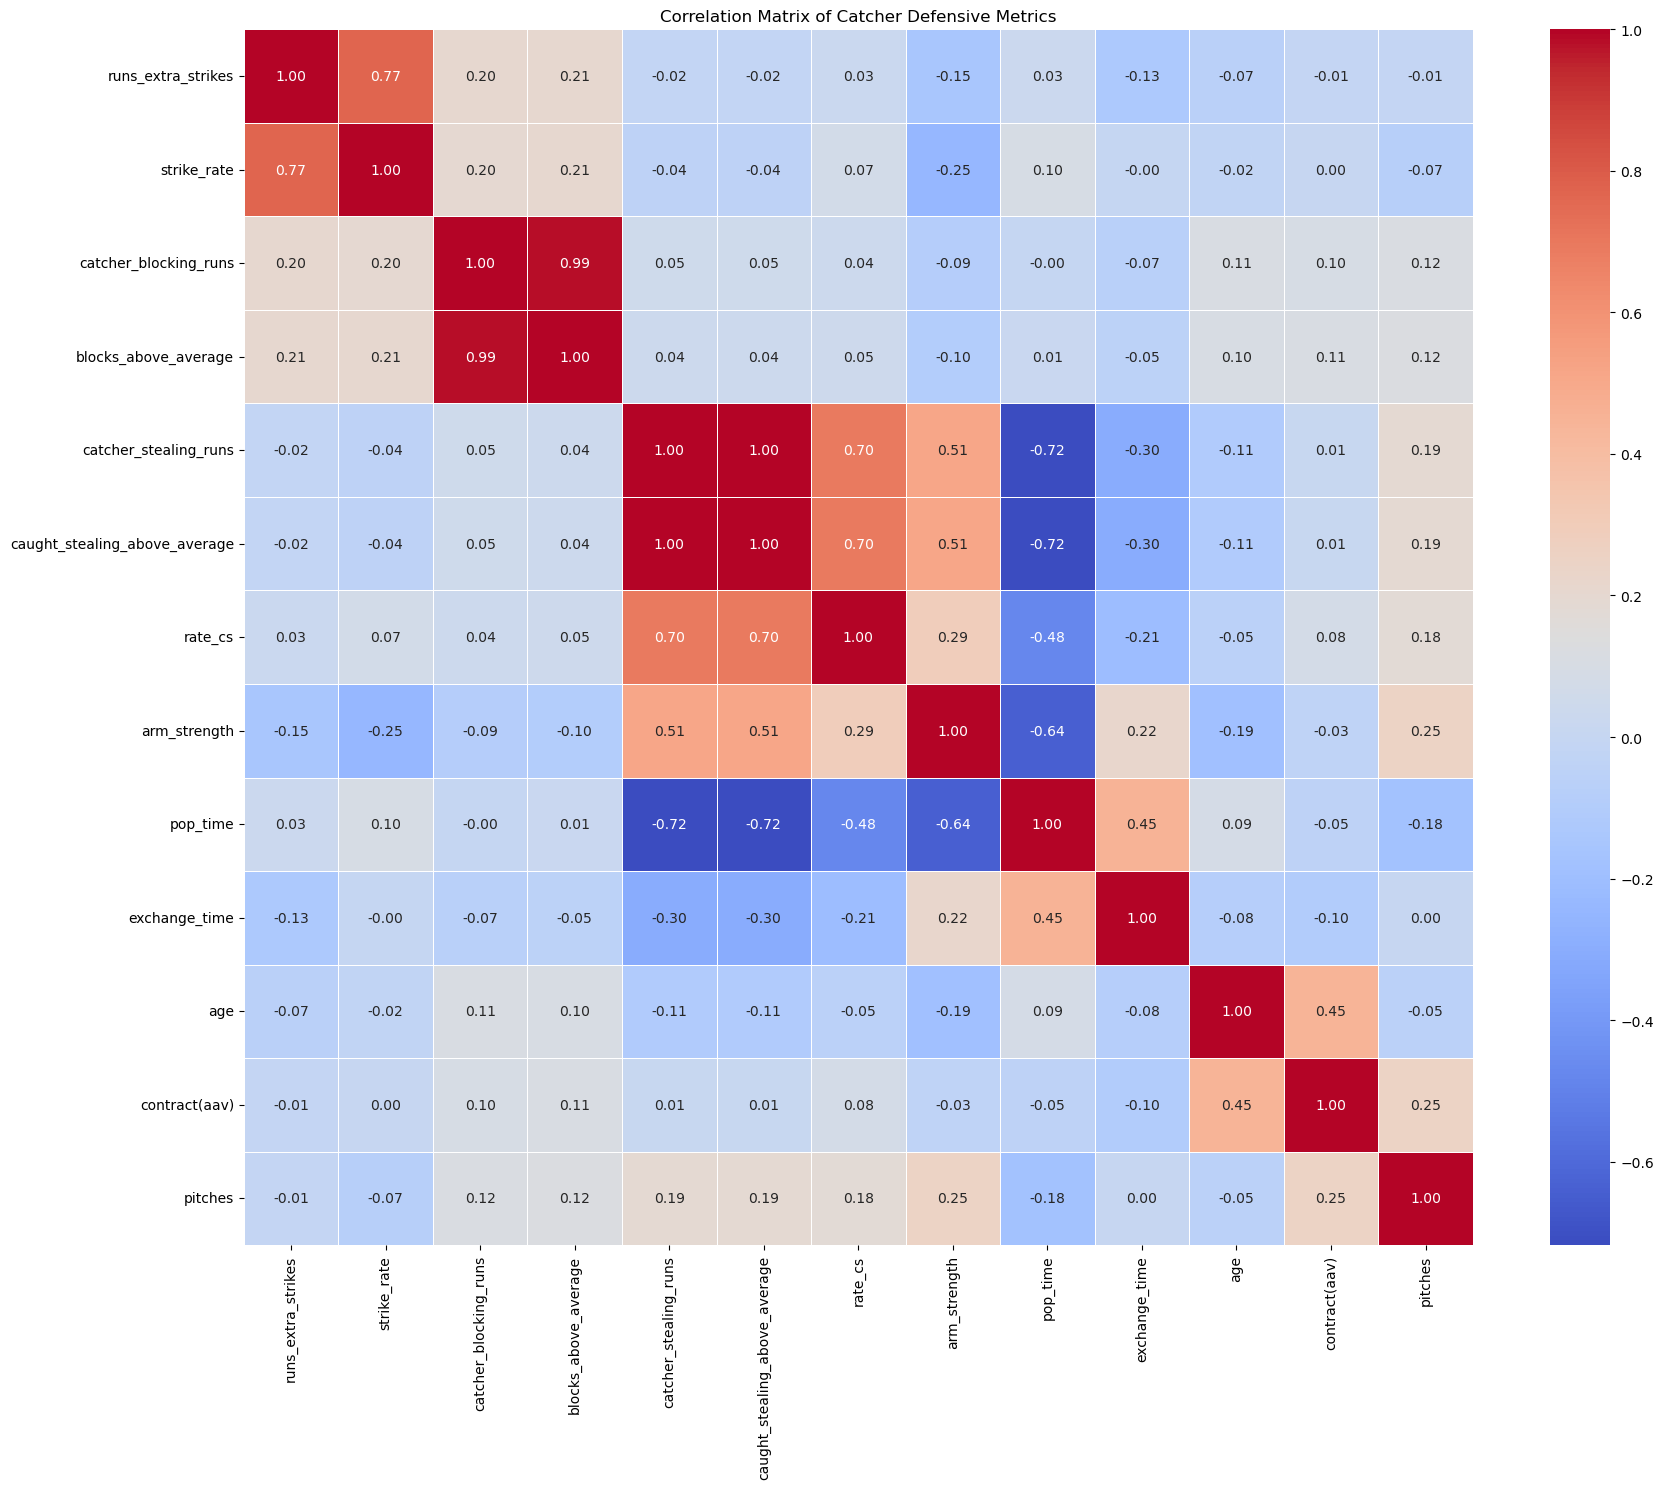

In [7]:
plt.figure(figsize = (18,15))
corr_matrix = df[key_variables].corr()
sns.heatmap(corr_matrix,annot = True,cmap = 'coolwarm',fmt = ".2f",linewidths = 0.5)
plt.title('Correlation Matrix of Catcher Defensive Metrics')
plt.tight_layout()
plt.savefig('correlation_matrix.png',dpi = 300,bbox_inches = 'tight')
plt.show()

**Histograms**

These are histograms of variables in the dataset to check if it is normally distributed or if there is skewness in the data.
All of the major variables are normally distributed which is beneficial for analysis as it removes bias in the model. There are no major outliers in the data, which will not impact the analysis

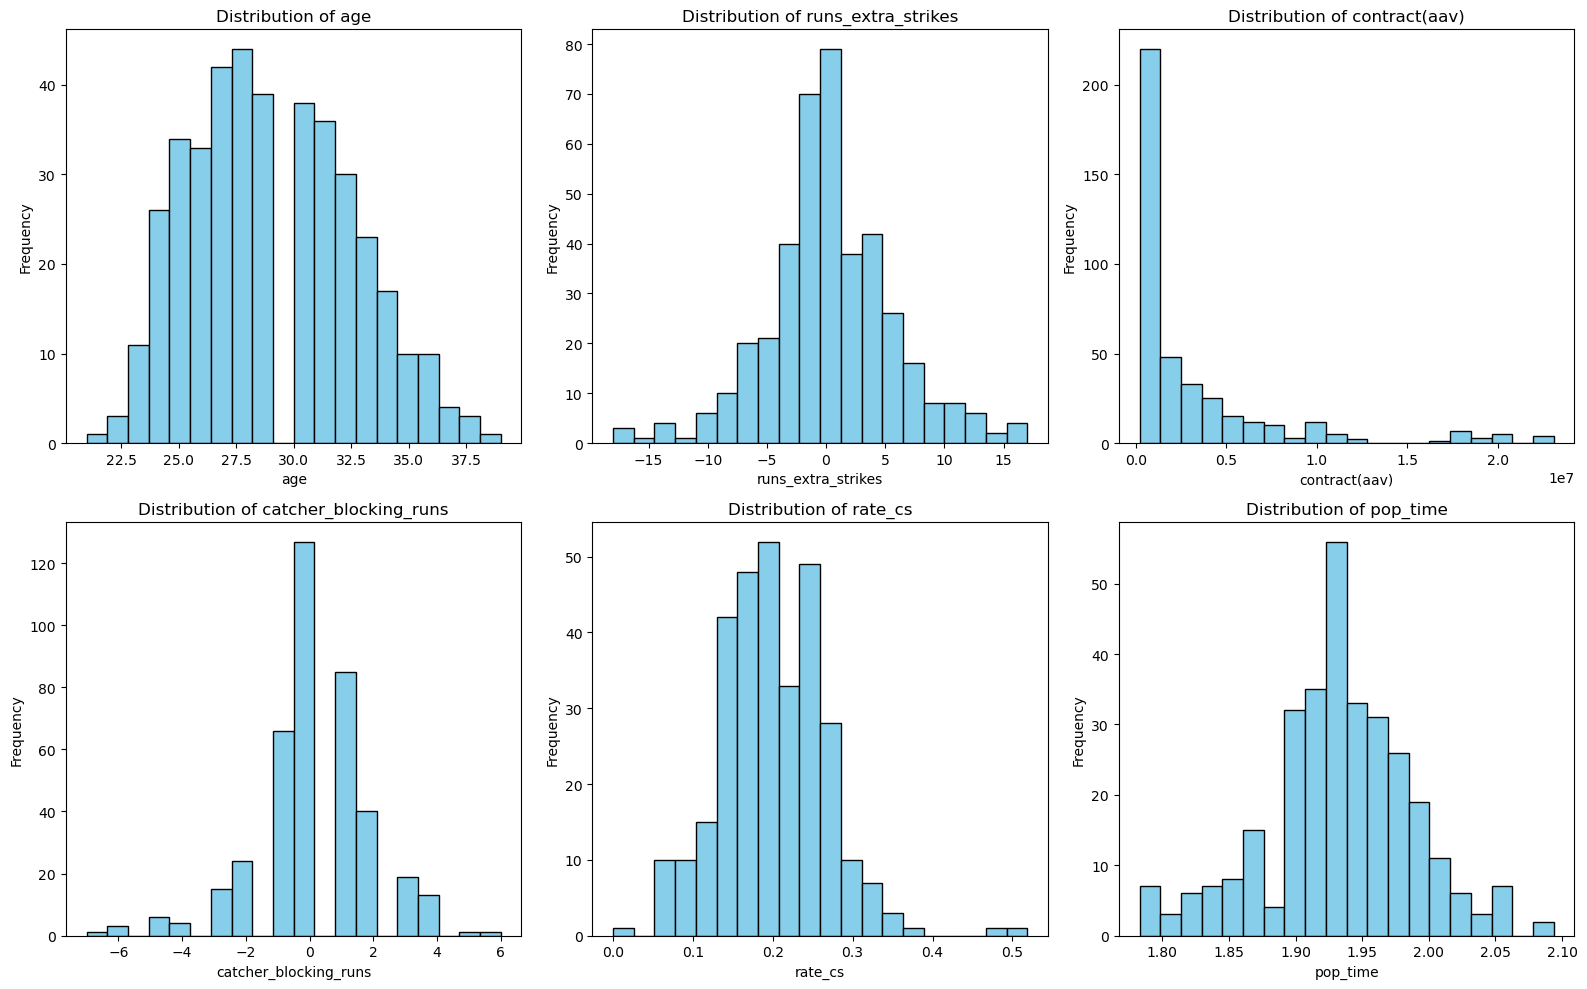

In [8]:

hist_vars = ['age', 'runs_extra_strikes','contract(aav)',
             'catcher_blocking_runs', 'rate_cs', 'pop_time']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
axes = axes.flatten()

for i, var in enumerate(hist_vars):
    df[var] = pd.to_numeric(df[var], errors='coerce')  # Clean the data
    clean_data = df[var].dropna()
    axes[i].hist(clean_data, bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
plt.savefig('histogram')
plt.tight_layout()
plt.show()


In [9]:
#This block selects a couple of key variables and describes their summary statistics to give us a better understanding of what the data looks like.

# Select key variables
summary_vars = ['age', 'contract(aav)', 'runs_extra_strikes',
                'catcher_blocking_runs', 'rate_cs', 'pop_time']

# Generate summary statistics
summary = df[summary_vars].describe().transpose()

# Rename columns for clarity
summary = summary.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'min': 'Minimum',
    '25%': '25th Percentile',
    '50%': 'Median',
    '75%': '75th Percentile',
    'max': 'Maximum'
})

# View or export
print(summary)

# Optional: Save to CSV or Excel
summary.to_csv("summary_statistics.csv")

                       Count          Mean  Standard Deviation        Minimum  \
age                    405.0  2.897037e+01        3.519270e+00      21.000000   
contract(aav)          405.0  3.208833e+06        4.573875e+06  190000.000000   
runs_extra_strikes     405.0  2.592593e-01        5.382355e+00     -18.000000   
catcher_blocking_runs  405.0  1.358025e-01        1.824972e+00      -7.000000   
rate_cs                311.0  1.993678e-01        6.610740e-02       0.000000   
pop_time               311.0  1.933365e+00        5.486526e-02       1.782903   

                       25th Percentile         Median  75th Percentile  \
age                          26.000000      29.000000     3.100000e+01   
contract(aav)            650000.000000  960000.000000     3.900000e+06   
runs_extra_strikes           -3.000000       0.000000     3.000000e+00   
catcher_blocking_runs        -1.000000       0.000000     1.000000e+00   
rate_cs                       0.154845       0.194175     2.45

In [10]:
# Reload dataset
file_path = "catcher_dataclean.xlsx"
df = pd.read_excel(file_path)

### Step 2 : Principal Component Analysis

To uncover patterns across the multiple correlated defensive metrics, we applied PCA. This dimensionality reduction technique condenses the data into a smaller number of components to explain most of the variance in the dataset.

PCA 1 - represents pop time and throwing efficiency

PCA 2 - represetns glove skills, meaning framing and blocking

The first two components explain 25.5% of the total variance.

In [11]:
# Select all numeric columns
# PCA only works with numeric columns, so all other non-numeric columns must be dropped.
numeric_cols = df.select_dtypes(include=['number']).columns
df_pca_all = df[numeric_cols]

In [12]:
# Step 2: Standardize the data (PCA is sensitive to scale)
# The data needs to be standardized to ensure all metrics are evaluated on the same scale, due to differences in measurement units.
scaler = StandardScaler()
df_scaled_all = scaler.fit_transform(df_pca_all)

In [13]:
# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(df_scaled_all)

In [14]:
# Add PCA results back to the DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
# Step 4: Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)

Explained Variance by Component: [0.13589185 0.12172909]


In [15]:
# Look at component loadings
component_loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=numeric_cols
)
component_loadings['abs_pc1'] = abs(component_loadings['PC1'])
# Sort by absolute contribution to PC1
sorted_loadings = component_loadings.sort_values('abs_pc1', ascending=False)
print("Feature contributions to principal components:")
print(sorted_loadings[['PC1', 'PC2']])

Feature contributions to principal components:
                                          PC1       PC2
catcher_stealing_runs                0.283557  0.049787
caught_stealing_above_average        0.283557  0.049787
pop_time                            -0.279761  0.020261
cs_aa_per_throw                      0.271320  0.034516
pitches                              0.246283  0.066173
n_called_pitches                     0.246096  0.076212
innings_caught                       0.243421  0.079659
arm_strength                         0.240649 -0.063820
n_xcs_with_flight_over_xcs           0.236924 -0.025311
pop_2b_sb                           -0.232683  0.021863
x_pbwp                               0.214033  0.141587
rate_cs                              0.208205  0.092926
n_pbwp                               0.202535 -0.019407
pop_2b_sba_count                     0.190051 -0.044324
est_cs_pct                          -0.142091  0.123160
n_cs                                 0.141000  0.217374
p

In [16]:
# Keep only the columns you want to export
export_df = sorted_loadings[['PC1', 'PC2']]

# Option 1: Save to CSV
export_df.to_csv("component_loadings.csv", index_label="Feature")

# Option 2: Save to Excel (requires openpyxl)
export_df.to_excel("component_loadings.xlsx", index_label="Feature")


C:\Users\jtegs\AppData\Local\Temp\ipykernel_30072\1391360618.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df['PCA1'], y=df['PCA2'], palette='coolwarm', alpha=0.7)


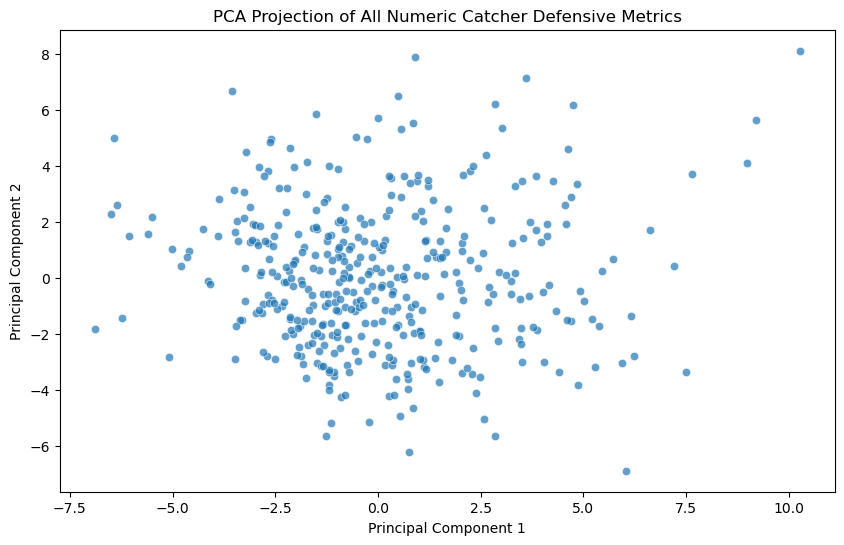

In [17]:
# Step 5: Visualize PCA Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of All Numeric Catcher Defensive Metrics")
plt.savefig("Scatterplot_Defensive_Metrics")
plt.show()

This PCA scatter plot shows that the majority of catchers cluster near the center, suggesting similar overall defensive profiles across most players, while a few outliers exhibit distinct combinations of defensive metrics that set them apart.

In [18]:
# Step 6: Display Explained Variance for Each Component
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance
})

In [19]:
explained_variance_df

,Principal Component,Explained Variance
0,PC1,0.135892
1,PC2,0.121729


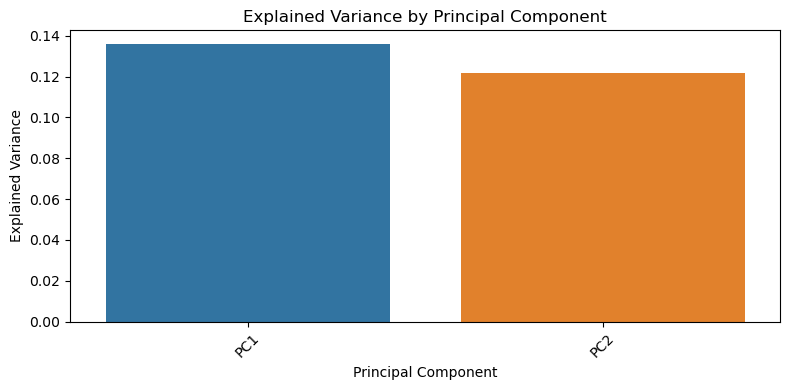

  Principal Component  Explained Variance
0                 PC1            0.135892
1                 PC2            0.121729


In [20]:
# Show explained variance
plt.figure(figsize=(8, 4))
sns.barplot(x='Principal Component', y='Explained Variance', data=explained_variance_df)
plt.title('Explained Variance by Principal Component')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('explained_variance')
plt.show()

# Or just display the dataframe directly
print(explained_variance_df)

The PCA explains 25.5% of the total variance in the data. 
this indicates that the catcher defensive metrics data is  complex, with information spread across many dimensions.

Explained Variance by Component: [0.13589185 0.12172909 0.09315016]
Cumulative Explained Variance: [0.13589185 0.25762095 0.35077111]
Feature contributions to principal components:
                                          PC1       PC2       PC3
catcher_stealing_runs                0.283557  0.049787 -0.209808
caught_stealing_above_average        0.283557  0.049787 -0.209808
pop_time                            -0.279761  0.020261  0.213768
cs_aa_per_throw                      0.271320  0.034516 -0.203313
pitches                              0.246283  0.066173  0.306470
n_called_pitches                     0.246096  0.076212  0.295333
innings_caught                       0.243421  0.079659  0.294093
arm_strength                         0.240649 -0.063820 -0.082347
n_xcs_with_flight_over_xcs           0.236924 -0.025311 -0.117735
pop_2b_sb                           -0.232683  0.021863  0.171609
x_pbwp                               0.214033  0.141587  0.304427
rate_cs                    

C:\Users\jtegs\AppData\Local\Temp\ipykernel_30072\2326286987.py:51: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df['PCA1'], y=df['PCA2'], palette='coolwarm', alpha=0.7)


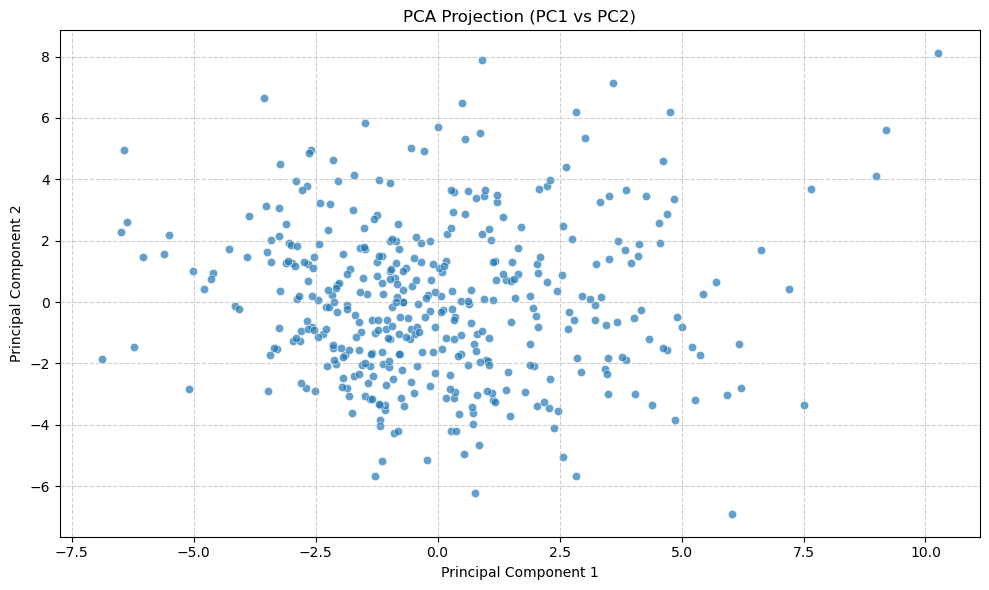

C:\Users\jtegs\AppData\Local\Temp\ipykernel_30072\2326286987.py:61: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df['PCA1'], y=df['PCA3'], palette='coolwarm', alpha=0.7)


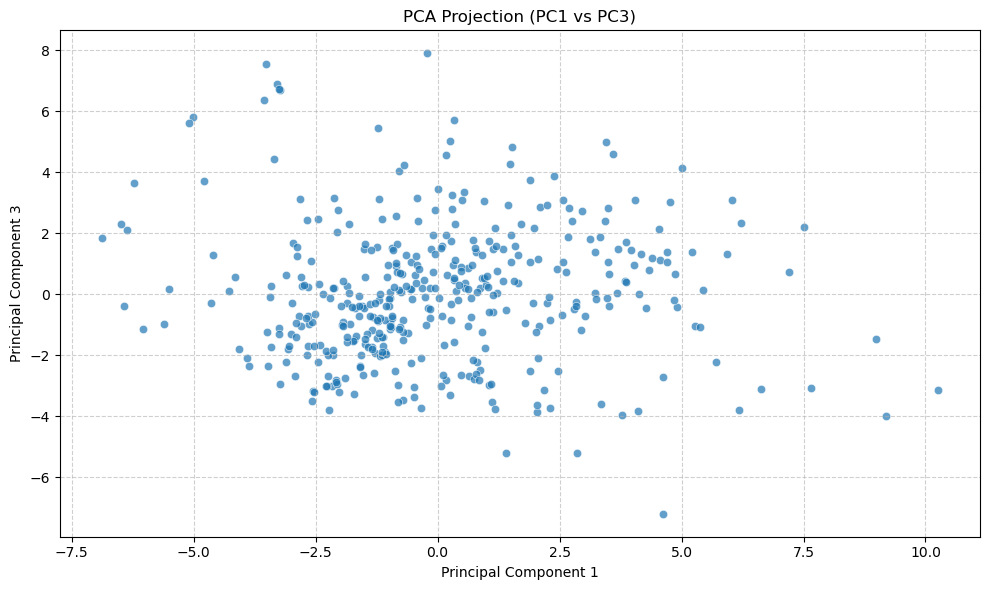

C:\Users\jtegs\AppData\Local\Temp\ipykernel_30072\2326286987.py:71: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df['PCA2'], y=df['PCA3'], palette='coolwarm', alpha=0.7)


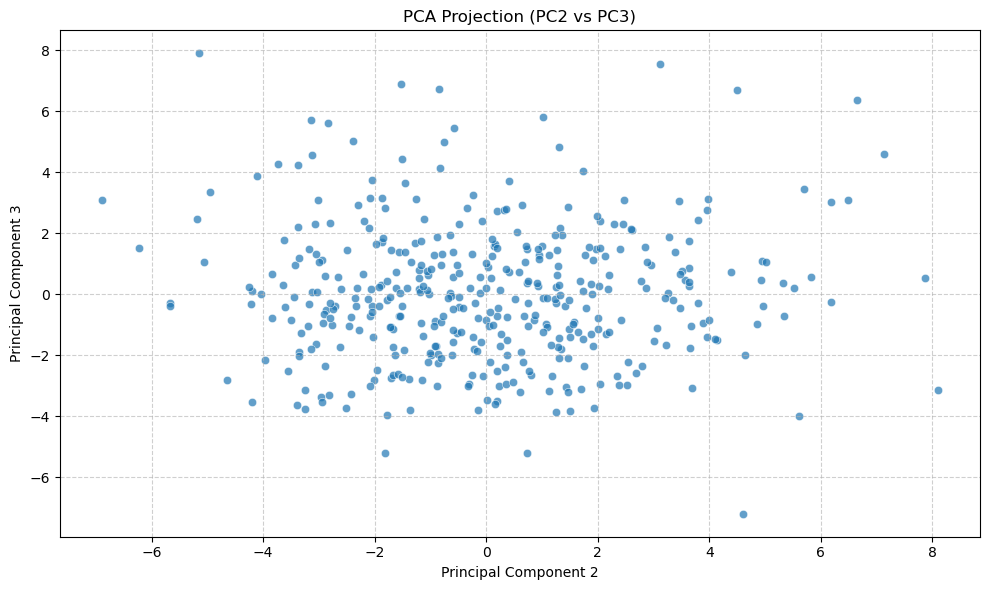

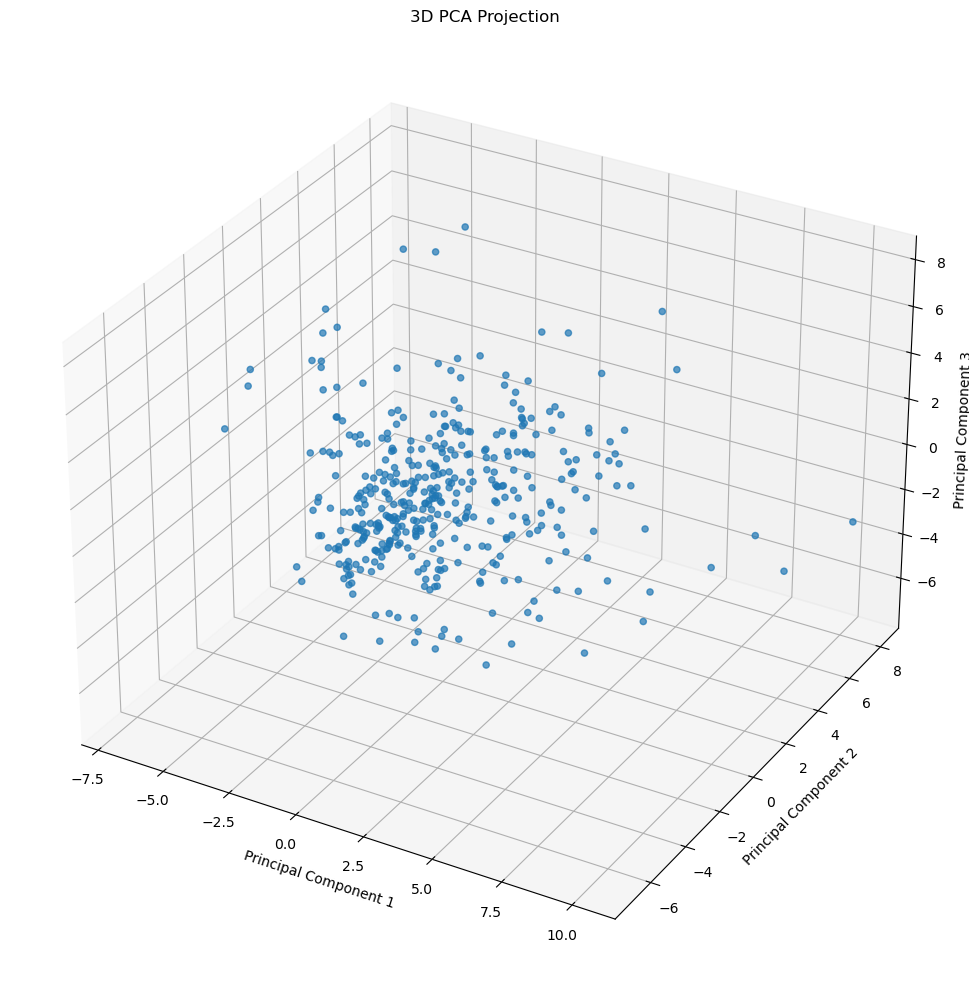

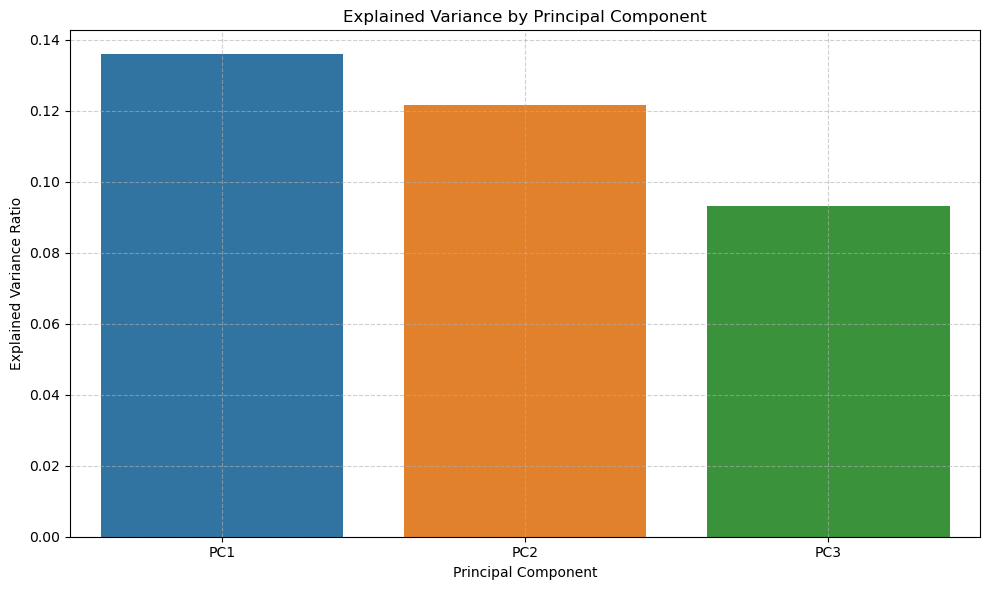

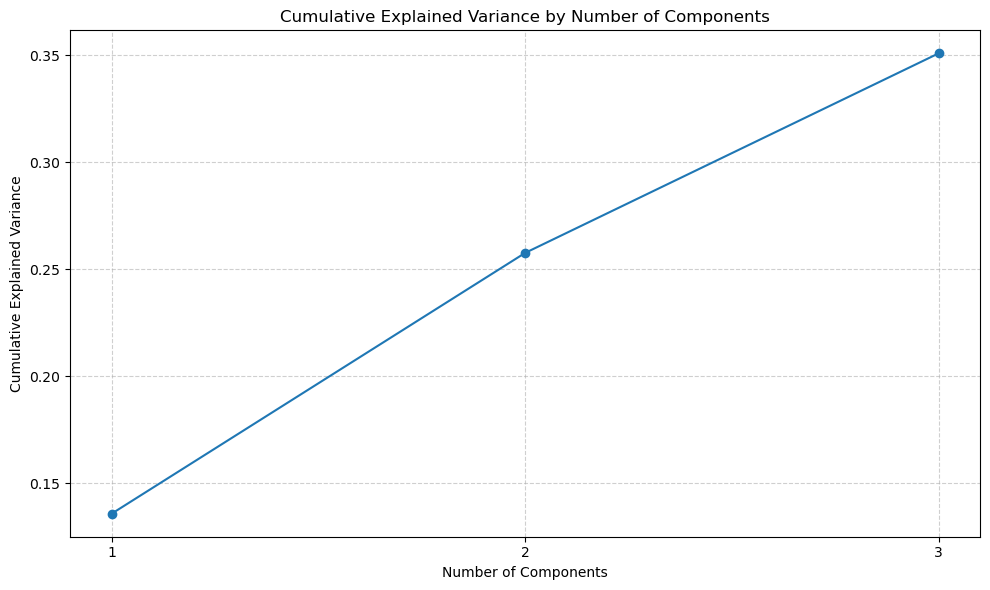


PCA Explained Variance:
  Principal Component  Explained Variance  Cumulative Variance
0                 PC1            0.135892             0.135892
1                 PC2            0.121729             0.257621
2                 PC3            0.093150             0.350771


In [21]:
# Step 1: Reload the dataset and select all numeric columns for PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Reload dataset
file_path = "catcher_dataclean.xlsx"
df = pd.read_excel(file_path)

# Select all numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df_pca_all = df[numeric_cols]

# Step 2: Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled_all = scaler.fit_transform(df_pca_all)

# Step 3: Apply PCA with 3 components
pca = PCA(n_components=3)  # Changed to 3 components
pca_result = pca.fit_transform(df_scaled_all)

# Add PCA results back to the DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
df['PCA3'] = pca_result[:, 2]  # Added third component

# Step 4: Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance))

# Look at component loadings
component_loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3'],  # Added PC3
    index=numeric_cols
)
component_loadings['abs_pc1'] = abs(component_loadings['PC1'])
# Sort by absolute contribution to PC1
sorted_loadings = component_loadings.sort_values('abs_pc1', ascending=False)
print("Feature contributions to principal components:")
print(sorted_loadings[['PC1', 'PC2', 'PC3']])  # Added PC3

# Step 5: Visualize PCA Results (2D plots)
# Plot PC1 vs PC2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA2'], palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (PC1 vs PC2)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot PC1 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA1'], y=df['PCA3'], palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 3")
plt.title("PCA Projection (PC1 vs PC3)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot PC2 vs PC3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['PCA2'], y=df['PCA3'], palette='coolwarm', alpha=0.7)
plt.xlabel("Principal Component 2")
plt.ylabel("Principal Component 3")
plt.title("PCA Projection (PC2 vs PC3)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 6: Create 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Projection')
plt.tight_layout()
plt.show()

# Step 7: Display Explained Variance for Each Component
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': np.cumsum(explained_variance)
})

# Show explained variance with standard plotting (replacing ace_tools)
plt.figure(figsize=(10, 6))
sns.barplot(x='Principal Component', y='Explained Variance', data=explained_variance_df)
plt.title('Explained Variance by Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Show cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, len(explained_variance) + 1))
plt.tight_layout()
plt.show()

# Display the dataframe directly (replacing ace_tools)
print("\nPCA Explained Variance:")
print(explained_variance_df)

This time, we reload the dataset and rerun the PCA analysis using five components, to further capture the explained variance in the model.  


Explained Variance by Component: [0.13589185 0.12172909 0.09315016 0.08430314 0.06123894]
Cumulative Explained Variance: [0.13589185 0.25762095 0.35077111 0.43507424 0.49631318]

Top contributors for each principal component:

PC1 top contributors:
catcher_stealing_runs            0.283557
caught_stealing_above_average    0.283557
pop_time                        -0.279761
cs_aa_per_throw                  0.271320
pitches                          0.246283
Name: PC1, dtype: float64

PC2 top contributors:
blocks_above_average             0.273944
catcher_blocking_runs            0.266424
blocks_above_average_per_game    0.255551
strike_rate                      0.238265
drs                              0.234271
Name: PC2, dtype: float64

PC3 top contributors:
pitches             0.306470
x_pbwp              0.304427
n_pbwp              0.301776
n_called_pitches    0.295333
innings_caught      0.294093
Name: PC3, dtype: float64

PC4 top contributors:
year                     0.316750
diff_

C:\Users\jtegs\Contacts\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

<Figure size 1500x1500 with 0 Axes>

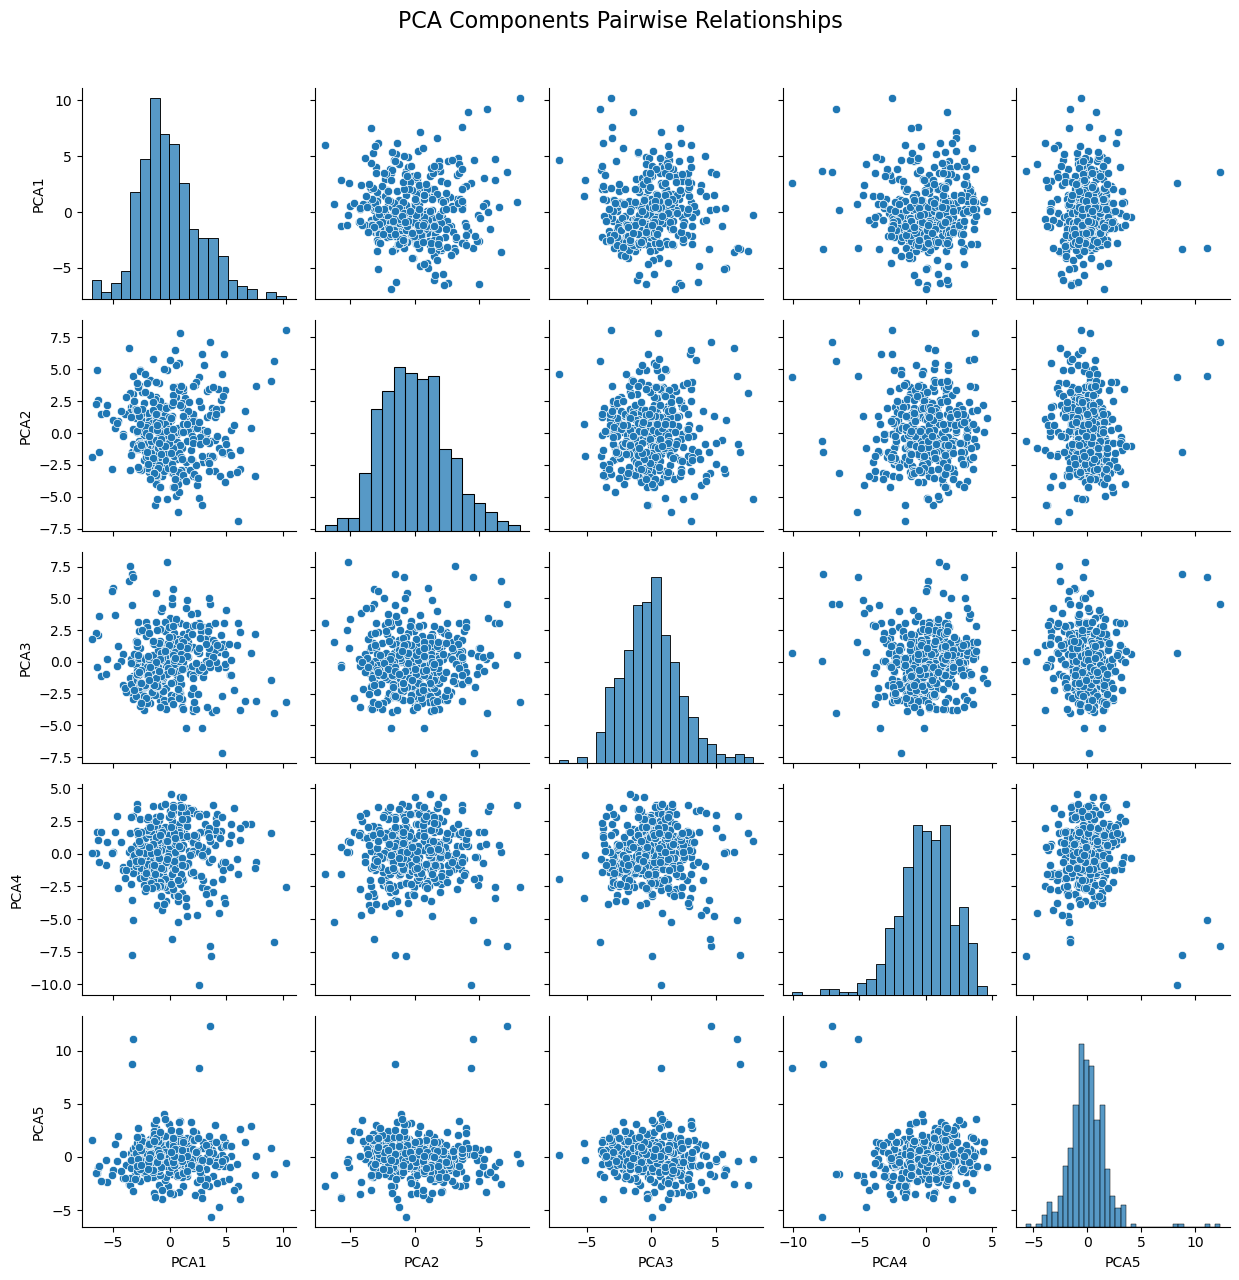

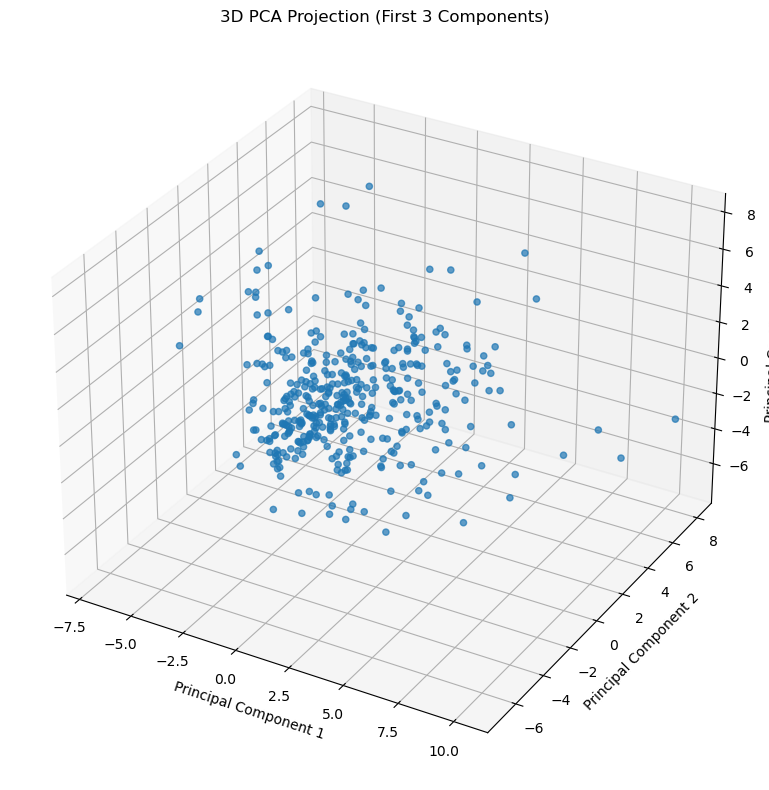

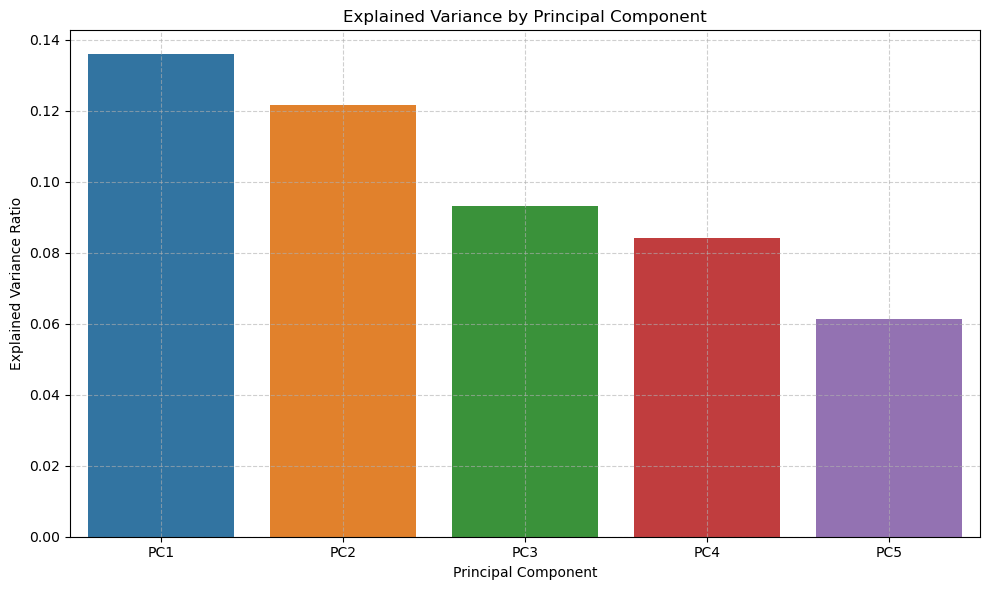

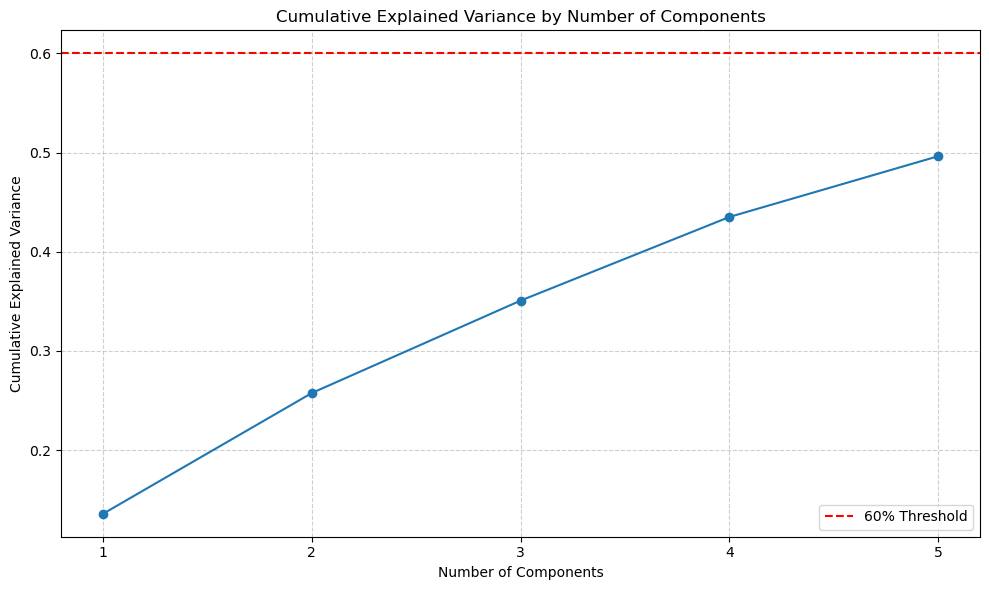


PCA Explained Variance:
  Principal Component  Explained Variance  Cumulative Variance
0                 PC1            0.135892             0.135892
1                 PC2            0.121729             0.257621
2                 PC3            0.093150             0.350771
3                 PC4            0.084303             0.435074
4                 PC5            0.061239             0.496313


In [22]:
# Step 1: Reload the dataset and select all numeric columns for PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Reload dataset
file_path = "catcher_dataclean.xlsx"
df = pd.read_excel(file_path)

# Select all numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df_pca_all = df[numeric_cols]

# Step 2: Standardize the data (PCA is sensitive to scale)
scaler = StandardScaler()
df_scaled_all = scaler.fit_transform(df_pca_all)

# Step 3: Apply PCA with 5 components
pca = PCA(n_components=5)  # Changed to 5 components
pca_result = pca.fit_transform(df_scaled_all)

# Add PCA results back to the DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
df['PCA3'] = pca_result[:, 2]
df['PCA4'] = pca_result[:, 3]
df['PCA5'] = pca_result[:, 4]

# Step 4: Explained Variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)
print("Cumulative Explained Variance:", np.cumsum(explained_variance))

# Look at component loadings
component_loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    index=numeric_cols
)

# Print top 5 contributors for each principal component
print("\nTop contributors for each principal component:")
for i in range(5):
    pc = f'PC{i+1}'
    print(f"\n{pc} top contributors:")
    # Sort by absolute contribution and show top 5
    temp_df = component_loadings[[pc]].copy()
    temp_df['abs_val'] = abs(temp_df[pc])
    print(temp_df.sort_values('abs_val', ascending=False).head(5)[pc])

# Step 5: Create matrix of 2D PCA plots (pairs plot)
pca_columns = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']
pca_df = df[pca_columns]
plt.figure(figsize=(15, 15))
sns.pairplot(pca_df)
plt.suptitle('PCA Components Pairwise Relationships', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Step 6: 3D visualization for first three components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Projection (First 3 Components)')
plt.tight_layout()
plt.show()

# Step 7: Display Explained Variance for Each Component
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': np.cumsum(explained_variance)
})

# Show explained variance with standard plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Principal Component', y='Explained Variance', data=explained_variance_df)
plt.title('Explained Variance by Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Show cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), 'o-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0.6, color='r', linestyle='--', label='60% Threshold')
plt.legend()
plt.xticks(range(1, len(explained_variance) + 1))
plt.tight_layout()
plt.show()

# Display the dataframe directly
print("\nPCA Explained Variance:")
print(explained_variance_df)

In the above code, we re run the PCA model, this time adding five components to better explain the variance in the model. After adding the 5th PCA, we are able to explain 48.6% of the data, with diminishing returns each time a new component is added.For example, while PC1 accounts for the largest share of variance, by the time we reach PC5, its contribution is considerably smaller. This suggests that the first few components capture the most meaningful structure in the data, while later components may reflect noise or more subtle patterns. The line chart begins to flatten as more components are added.

### Step 3 : K-Means Clustering

To group catchers into defensive performance tiers, we apply k-means clustering to the PCA-transformred data. Using the elbow method, we determine the optimal number of clusters to be four.


- **Cluster 0**: Balanced, high-performing defenders
- **Cluster 1**: Elite framers/blockers
- **Cluster 2**: Elite throwers
- **Cluster 3**: Below-average performers


In [23]:
# Step 1: Use the PCA components for clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [24]:
# Extract the 5 PCA components as our clustering features
X_cluster = df[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']].values

In [25]:
# Step 2: Determine optimal number of clusters using the Elbow Method
distortions = []
K_range = range(1, 11)  # Test 1-10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(X_cluster)
    distortions.append(sum(np.min(cdist(X_cluster, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_cluster.shape[0])

C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans 

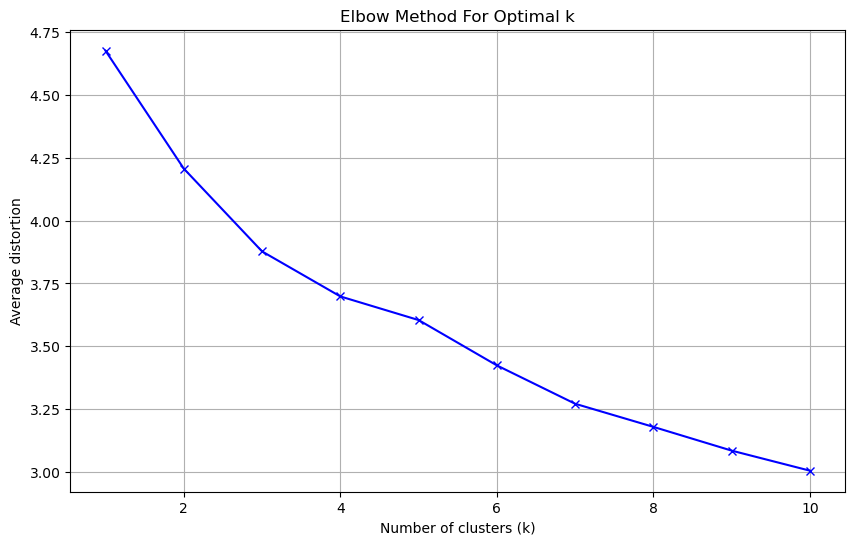

In [28]:
# Plot Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average distortion')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow_method')
plt.grid(True)
plt.show()

In [27]:
# Step 2: Apply K-means with k=4 based on the elbow plot analysis
k = 4  # The optimal number of clusters we determined
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_cluster)

C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


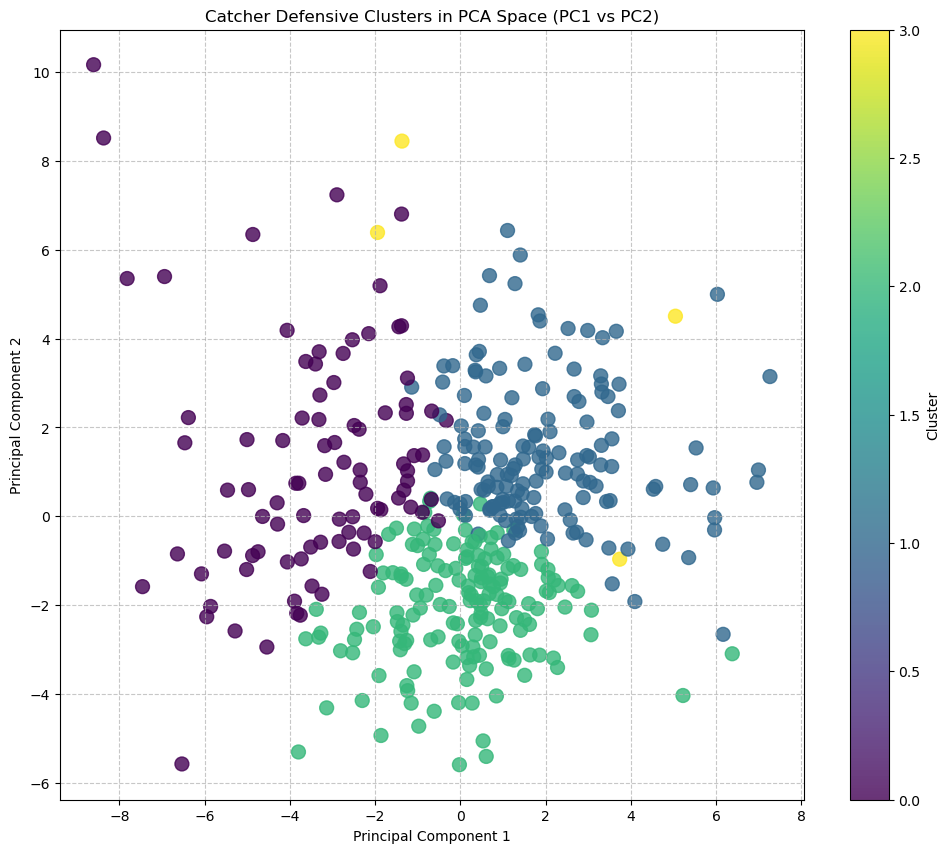

In [28]:
# Step 3: Visualize clusters in PCA space (first 2 components)
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], 
                     cmap='viridis', s=100, alpha=0.8)
plt.title('Catcher Defensive Clusters in PCA Space (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("defensivecluster_kmeans")
plt.colorbar(scatter, label='Cluster')

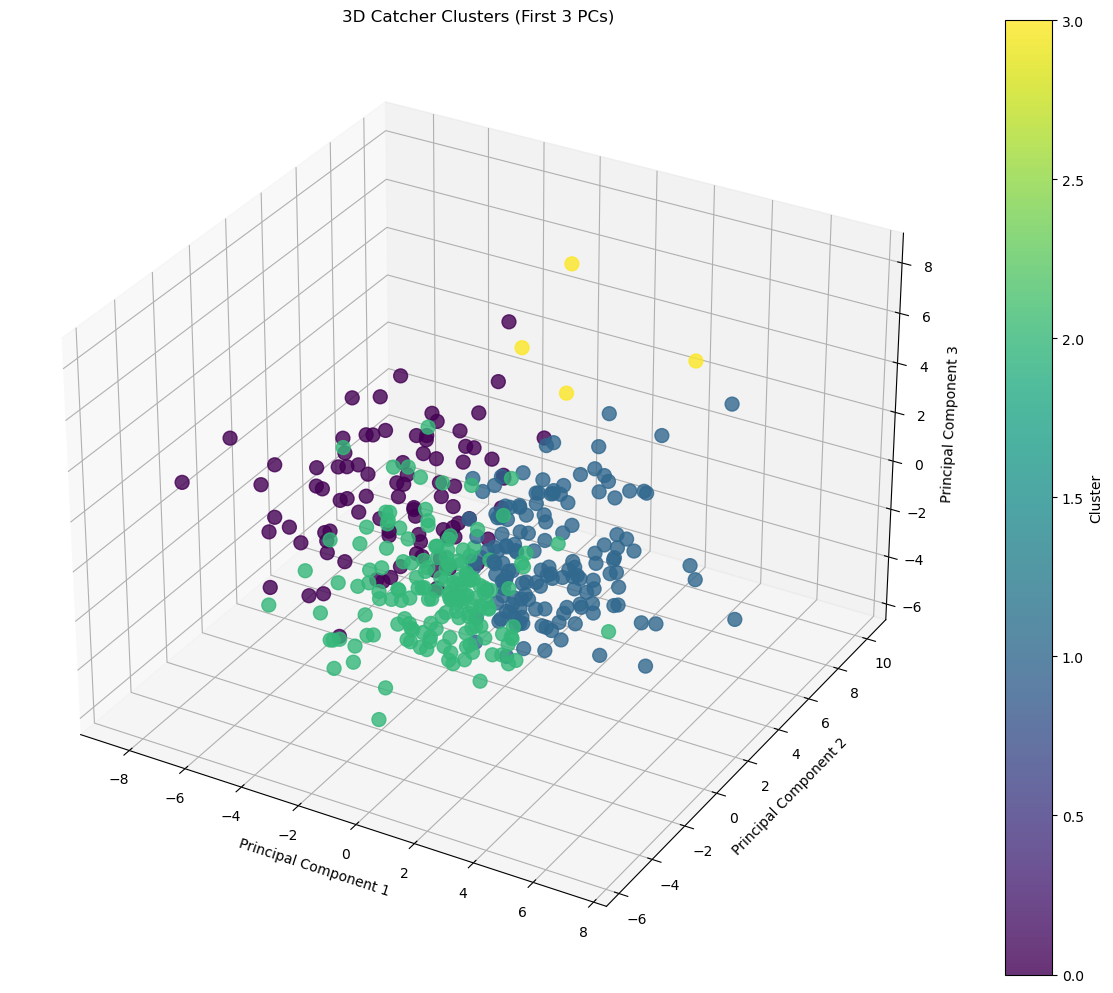

In [29]:
# Step 4: Create 3D visualization of first 3 PCs with cluster colors
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], 
                    c=df['Cluster'], cmap='viridis', s=100, alpha=0.8)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Catcher Clusters (First 3 PCs)')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

This PCA scatterplot shows how catcher seasons cluster based on their defensive skillsets. Each point represents a catcher’s performance, projected across two principal components: PCA1 (throwing and pop time) and PCA2 (framing and blocking). The K-means clustering algorithm grouped catchers into four performance tiers, with each cluster highlighting similar defensive profiles. This visual reveals how certain players specialize in glove skills while others excel in throwing, helping to differentiate well-rounded defenders from those with specific strengths or weaknesses.

In [30]:
# Step 5: Analyze cluster characteristics
# Select numeric columns for analysis (excluding PCA and Cluster)
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if not col.startswith('PCA') and col != 'Cluster']


In [31]:
# Choose metrics where higher values = better performance
positive_metrics = [
    'blocks_above_average',
    'runs_extra_strikes',
    'caught_stealing_above_average',
    'arm_strength'
]
negative_metrics = [
    'sb_attempts',
    'pop_time',
    'exchange_time',
    'n_pbwp'
]

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = df.copy()

# Normalize the selected metrics
for metric in positive_metrics:
    if metric in df.columns:
        df_norm[metric + '_norm'] = scaler.fit_transform(df[[metric]])

# Create a weighted or average score
df_norm['Performance_Score'] = df_norm[[m + '_norm' for m in positive_metrics]].mean(axis=1)


This graph shows the top catcher seasons with their performance score. J.T. Realmuto has been an elite all around defensive catcher for a couple of years now, as well as Sean Murphy. Players that can dominate in all four categories of defense perform the best in the scoring model, as reflected in this chart.

In [33]:
top_catchers = df_norm[['player_name', 'year', 'Performance_Score']].sort_values(by='Performance_Score', ascending=False)
top_catchers.head(10)


,player_name,year,Performance_Score
82,"Realmuto, J.T.",2019,0.840209
21,"Realmuto, J.T.",2018,0.753947
209,"Realmuto, J.T.",2021,0.726758
195,"Murphy, Sean",2021,0.704887
146,"Realmuto, J.T.",2020,0.702563
268,"Realmuto, J.T.",2022,0.701209
321,"Murphy, Sean",2023,0.696324
260,"Murphy, Sean",2022,0.689066
76,"Perez, Roberto",2019,0.675330
350,"Bailey, Patrick",2024,0.671103


In [34]:
# Step 6: Identify the top catchers in each cluster

# Use the correct column name for player names
name_column = 'player_name'
print(f"Using '{name_column}' as the player name column")

# Create performance score
df['Performance_Score'] = 0
for metric in positive_metrics:
    if metric in df.columns:
        min_val = df[metric].min()
        max_val = df[metric].max()
        if max_val > min_val:  # Avoid division by zero
            df['Performance_Score'] += (df[metric] - min_val) / (max_val - min_val)
        
for metric in negative_metrics:
    if metric in df.columns:
        min_val = df[metric].min()
        max_val = df[metric].max()
        if max_val > min_val:  # Avoid division by zero
            df['Performance_Score'] -= (df[metric] - min_val) / (max_val - min_val)

# Find top catchers in each cluster
for i in range(k):
    cluster_df = df[df['Cluster'] == i].sort_values('Performance_Score', ascending=False)
    print(f"\nTop Catchers in Cluster {i}:")
    # Always include the name column first
    display_cols = [name_column, 'Performance_Score']
    display_cols.extend([m for m in positive_metrics + negative_metrics if m in df.columns][:5])  # Limit to first 5 metrics for readability
    print(cluster_df[display_cols].head(3))

# Overall top catchers 
print("\nOverall Top 10 Catchers:")
top_overall = df.sort_values('Performance_Score', ascending=False).head(10)
print(top_overall[display_cols])

Using 'player_name' as the player name column

Top Catchers in Cluster 0:
         player_name  Performance_Score  blocks_above_average  \
350  Bailey, Patrick           1.898115                    -1   
146   Realmuto, J.T.           1.866394                     7   
362   Fermin, Freddy           1.810554                     9   

     runs_extra_strikes  caught_stealing_above_average  arm_strength  \
350                  16                       9.591498     81.528882   
146                   3                      23.298616     83.313038   
362                  -1                       7.376094     82.094796   

     sb_attempts  
350         69.0  
146        224.0  
362         27.0  

Top Catchers in Cluster 1:
        player_name  Performance_Score  blocks_above_average  \
391    Rogers, Jake           1.417723                     8   
305  Hedges, Austin           1.274305                     8   
76   Perez, Roberto           1.158124                    24   

     runs_extra

In [35]:
# Convert 'pop_2b_cs' to numeric and fill NaNs with the column mean
df['pop_2b_cs'] = pd.to_numeric(df['pop_2b_cs'], errors='coerce')
df['pop_2b_cs'].fillna(df['pop_2b_cs'].mean(), inplace=True)


### Step 4 - Revised Scoring Model:

To holisictally evaluate each cathcer, we developed a revised scoring system that assigns weights to each defensive skill based on importance and difficulty.

Framing - 2.0: A highly important and valuable skill for a catcher.

Blocking - 1.0: Not as important as framing for catchers.

Arm Weight - 1.5: This skill falls in between blocking and framing in terms of importance.

This score provides a single value to evaluate all catchers and their performance on defense all-around.

In [36]:
# Create an improved performance score
df['Revised_Score'] = 0

# Define weights for different skills (adjust based on research/consensus)
framing_weight = 2.0     # Framing is highly valued
blocking_weight = 1.0    # Blocking is important but less so than framing
arm_weight = 1.5         # Throwing/arm strength somewhere in between

# Apply weighted normalization to major metrics
# Framing (higher is better)
if 'runs_extra_strikes' in df.columns:
    min_val = df['runs_extra_strikes'].min()
    max_val = df['runs_extra_strikes'].max()
    if max_val > min_val:
        df['Revised_Score'] += framing_weight * (df['runs_extra_strikes'] - min_val) / (max_val - min_val)

# Blocking (higher is better)
if 'catcher_blocking_runs' in df.columns:
    min_val = df['catcher_blocking_runs'].min()
    max_val = df['catcher_blocking_runs'].max()
    if max_val > min_val:
        df['Revised_Score'] += blocking_weight * (df['catcher_blocking_runs'] - min_val) / (max_val - min_val)

# Arm strength (higher is better)
if 'maxeff_arm_2b_3b_sba' in df.columns:
    min_val = df['maxeff_arm_2b_3b_sba'].min()
    max_val = df['maxeff_arm_2b_3b_sba'].max()
    if max_val > min_val:
        df['Revised_Score'] += arm_weight * (df['maxeff_arm_2b_3b_sba'] - min_val) / (max_val - min_val)

# Pop time (lower is better)
if 'pop_2b_cs' in df.columns:
    min_val = df['pop_2b_cs'].min()
    max_val = df['pop_2b_cs'].max()
    if max_val > min_val:
        df['Revised_Score'] += arm_weight * (1 - (df['pop_2b_cs'] - min_val) / (max_val - min_val))

# Print top 10 catchers based on revised score
print("\nTop 10 Catchers (Revised Score):")
top_revised = df.sort_values('Revised_Score', ascending=False).head(10)
print(top_revised[['player_name', 'Revised_Score', 'runs_extra_strikes', 'catcher_blocking_runs', 'maxeff_arm_2b_3b_sba', 'pop_2b_cs']])


Top 10 Catchers (Revised Score):
         player_name  Revised_Score  runs_extra_strikes  \
350  Bailey, Patrick       5.272187                  16   
280    Trevino, Jose       5.184327                  17   
76    Perez, Roberto       5.110244                  12   
82    Realmuto, J.T.       5.083066                   8   
287  Bailey, Patrick       5.045993                  17   
321     Murphy, Sean       5.008258                   7   
305   Hedges, Austin       4.992436                  14   
55    Hedges, Austin       4.967673                  16   
195     Murphy, Sean       4.946027                  10   
209   Realmuto, J.T.       4.942479                   6   

     catcher_blocking_runs  maxeff_arm_2b_3b_sba  pop_2b_cs  
350                      0                  84.6       1.83  
280                      4                  77.8       1.95  
76                       6                  82.6       1.97  
82                       4                  88.4       1.88  
287   

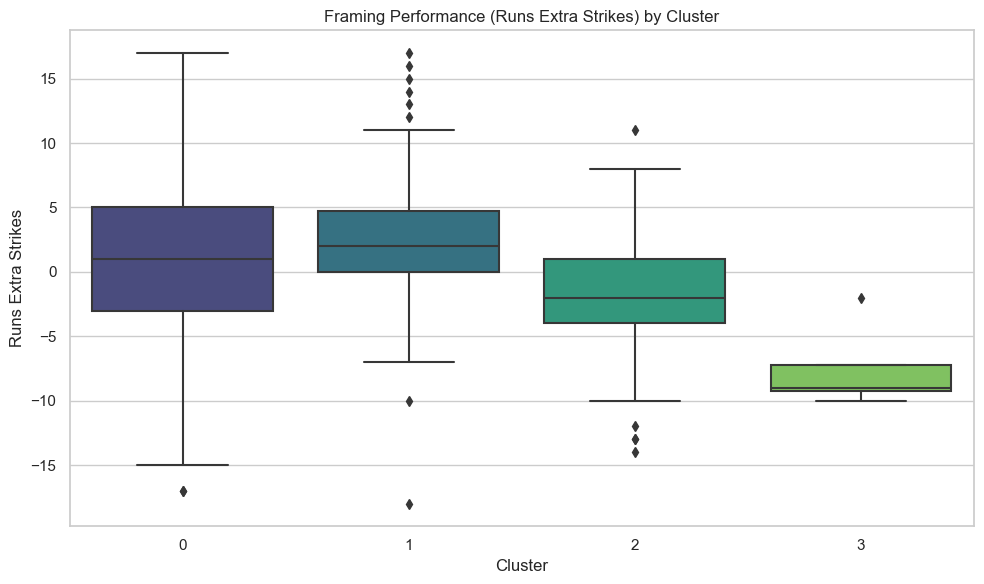

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Plot: Boxplot of runs_extra_strikes by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='runs_extra_strikes', palette='viridis')
plt.title('Framing Performance (Runs Extra Strikes) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Runs Extra Strikes')
plt.tight_layout()
plt.savefig("framing_boxplot")
plt.show()


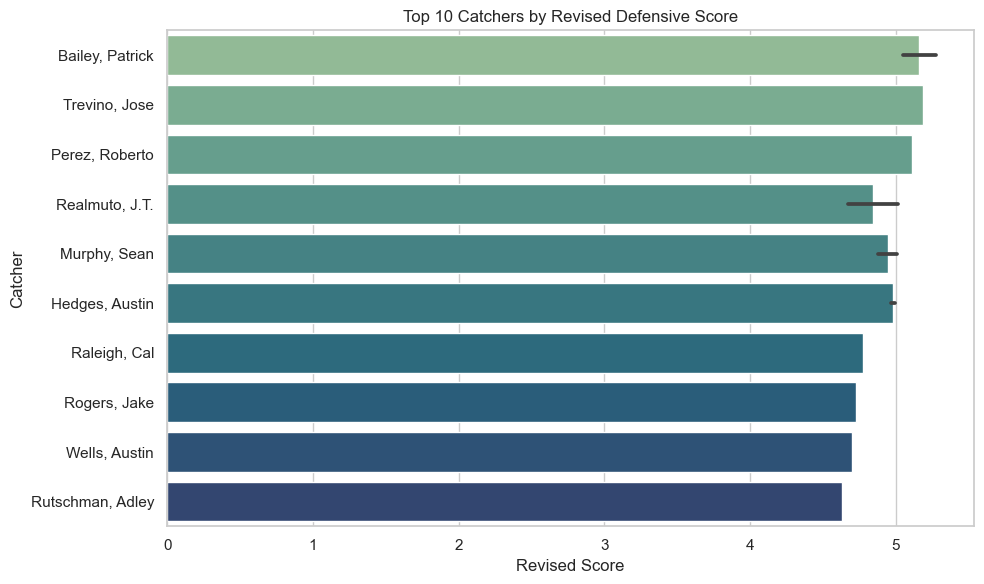

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort top_revised again to ensure it's in correct order for plotting
top_revised = df.sort_values('Revised_Score', ascending=False).head(17)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_revised, y='player_name', x='Revised_Score', palette='crest')
plt.title('Top 10 Catchers by Revised Defensive Score')
plt.xlabel('Revised Score')
plt.ylabel('Catcher')
plt.tight_layout()
plt.savefig('t10_catchers')
plt.show()


<Figure size 1200x800 with 0 Axes>

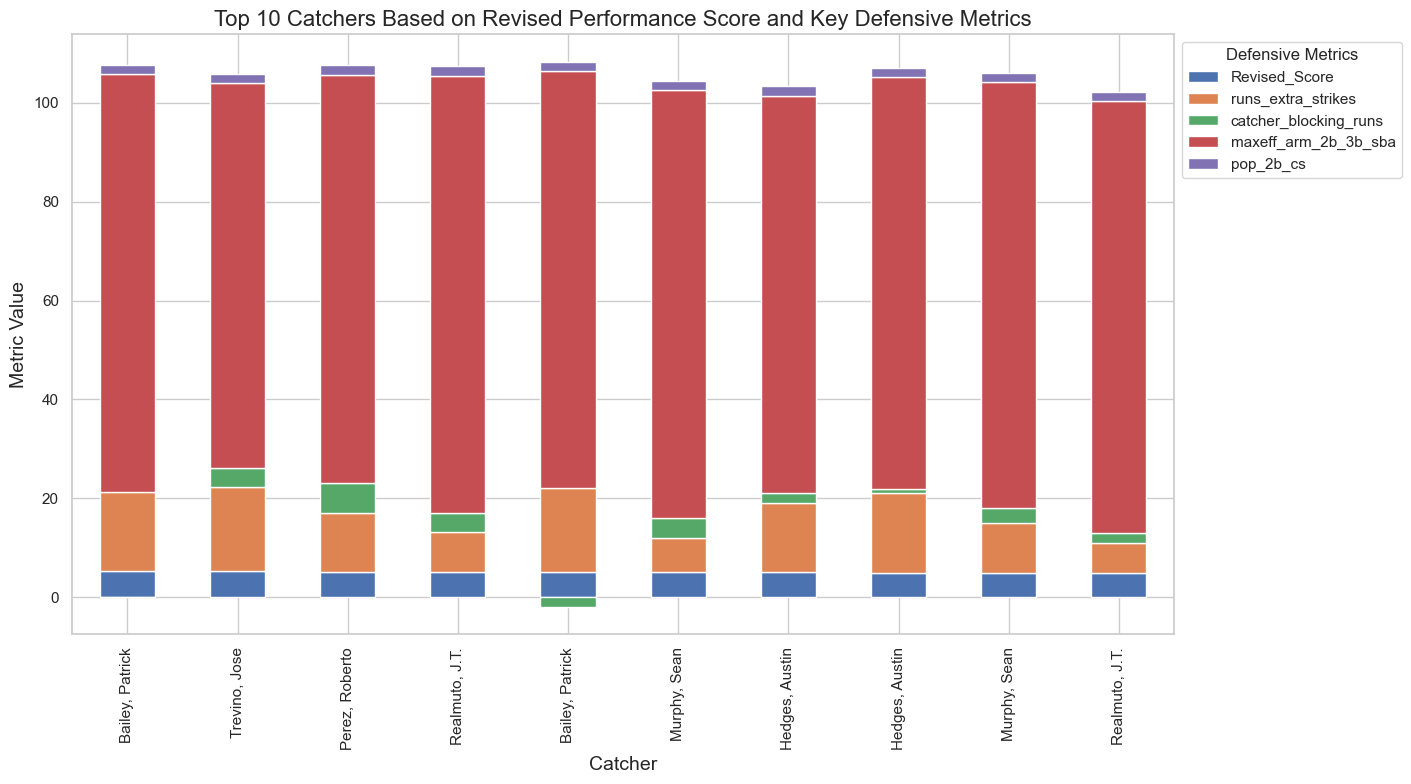

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 catchers based on the revised score
top_10 = df.sort_values('Revised_Score', ascending=False).head(10)

# Set up the figure size and plot style
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Plot a barplot for the top 10 catchers with their revised score and key metrics
top_10_plot = top_10[['player_name', 'Revised_Score', 'runs_extra_strikes', 'catcher_blocking_runs', 'maxeff_arm_2b_3b_sba', 'pop_2b_cs']]

# Creating a stacked bar plot
top_10_plot.set_index('player_name').plot(kind='bar', stacked=True, figsize=(12, 8))

# Add titles and labels
plt.title('Top 10 Catchers Based on Revised Performance Score and Key Defensive Metrics', fontsize=16)
plt.xlabel('Catcher', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.tight_layout()
plt.savefig('revisedscoreplusmetrics')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Defensive Metrics")

plt.show()


In [40]:
df.head()

,player_id,player_name,team_name,year,pitches,age,contract(aav),catcher_blocking_runs,blocks_above_average,n_pbwp,...,pop_3b_sb,Unnamed: 57,PCA1,PCA2,PCA3,PCA4,PCA5,Cluster,Performance_Score,Revised_Score
0,595751,"Alfaro, Jorge",PHI,2018,3659,25,547000,-5,-19,58,...,1.49,NaN,-4.289593,-0.175595,2.760586,-4.606799,-3.984954,0,0.080336,4.454039
1,605131,"Barnes, Austin",LAD,2018,1690,28,555000,2,9,9,...,\n,NaN,7.266841,3.145541,-1.991967,1.101151,-1.565435,1,-0.062361,3.993634
2,571466,"Barnhart, Tucker",CIN,2018,4503,27,4000000,4,18,22,...,1.5,NaN,0.445663,3.711572,2.381437,1.639355,2.848627,1,-0.512043,2.968010
3,605170,"Caratini, Victor",CHC,2018,1337,24,547500,1,3,12,...,1.7,NaN,3.557769,1.743121,0.580397,-2.009900,0.498675,1,-0.339377,3.547249
4,455139,"Chirinos, Robinson",TEX,2018,4158,34,2350000,4,14,28,...,\n,1.64,5.048564,4.504046,6.780799,-1.819407,11.892021,3,-0.425860,2.432937


In [41]:
df.groupby('Cluster')[['age', 'contract(aav)', 'Revised_Score']].mean().round(2)


,age,contract(aav),Revised_Score
Cluster,,,
0,28.09,3956826.21,4.17
1,29.31,3164432.34,4.03
2,29.16,2886565.32,3.74
3,28.50,1015250.00,2.30


### Step 5 - Analyzing Score vs. Salary and Age

Next, we investigate how the revised score from earlier relates to a player's age and contract value.

Age - to explore aging curves and career performance

Contract AAV - to explore market ineffiencies

This analysis shows that several elite defenders(Bailey and Trevino) may be underpaid relative to defensive value, and some lower-scoring catchers have high AAV's likely due to offensive production.

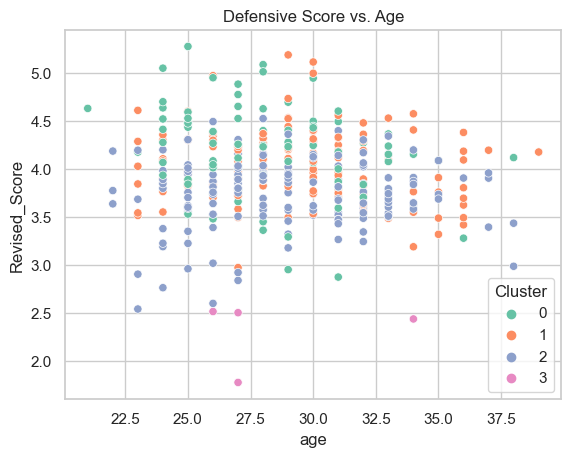

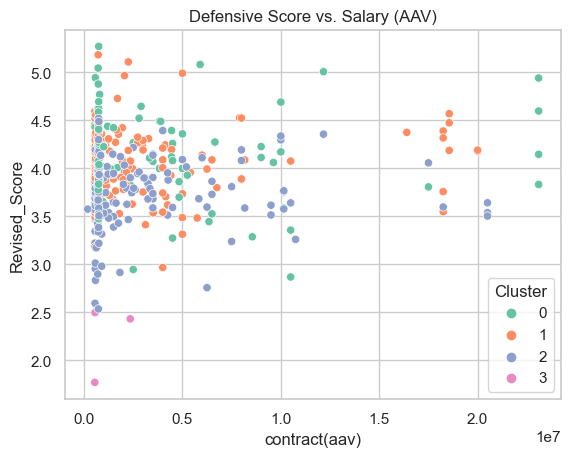

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Score vs Age
sns.scatterplot(data=df, x='age', y='Revised_Score', hue='Cluster', palette='Set2')
plt.title('Defensive Score vs. Age')
plt.savefig('score_age')
plt.show()




# Score vs AAV
sns.scatterplot(data=df, x='contract(aav)', y='Revised_Score', hue='Cluster', palette='Set2')
plt.title('Defensive Score vs. Salary (AAV)')
plt.savefig('salary_age')
plt.show()


**Age vs Defensive Score**

This plot shows no strong trend between age and defensive score, suggesting defensive value is relatively stable across age groups. Players in Cluster 0 and 1 (top performers) appear consistently throughout the age spectrum, indicating that elite defense is not limited to younger players. Cluster 3 catchers, the lowest scoring, are sparse and mostly younger, pointing to possible development gaps or less experience.

**Salary vs Defensive Score**

This scatterplot reveals a disconnect between defensive ability and salary. Several high-performing catchers in Clusters 0 and 1 earn less than peers with similar or lower scores, highlighting potential undervaluation. At the same time, some well-paid players, on the far right of the chart, don’t appear to be elite defenders, suggesting salary may reflect offensive output or veteran status rather than defensive value alone.

## Final Thoughts

This notebook demonstrates how statistical modeling techniques can be used to evaluate catcher defense, support contract decisions, and inform front office strategy. Future work could incorporate offensive data to evaluate total player value or examine multi-year performance stability.
